In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")

# First steps and decisions made in order to work with a clean and easily understable dataset:

- Transform the dates to datetime format.

- Interpret values with the caracter "?" as null values.

- Look if there are any duplicated rows, inconsistent information or unwanted outliers, in this case, there is none.

- Change the original columns name to a consistent format, concatenate the old with the new data.

- Create new columns with additional information based on the original dataset:
    - Year : (int) represents the year of occurence
    - Month : (int) represents the month of occurence.
    - Dayofweek (object) represents the day of the week on wich the crash occurred.
    - Climatic (bool) if the summary mentions the topic "storm" or "thunder".
    - Criminal activities (bool) if the summary mentions the topic "hijack" or "terrorism".
    - Military operation (bool) whether or not the operator column contains the words "military" and "army" and whether or not the summary mentions the topic "army" or "military".
    - Country (object) Country where the crash took place.
#
- Drop unwanted columns:
    - Registration, cn/ln and Flight # : We don't want to identify the aircraft or the flight in particular, the main focus of this to work in the overall context to identify general anomalies or patterns.
    - Aboard Passangers, Aboard Crew, Fatalities Passangers and Ground: The scope of this project is to work on the total number of fatalities, regardless of the role of the person.
#
- Fill categorical missing values with "Unknown" and set the correct dtypes for the columns.

Now, with a clean and easily understable dataset, we can start with the data analysis.

In [2]:
df = pd.read_csv('src/datasets/AirplaneCrashes.csv', parse_dates=['Date'])

In [3]:
df.head(2)

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,1908-09-17,1718,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   5016 non-null   datetime64[ns]
 1   Time                   3512 non-null   object        
 2   Location               5011 non-null   object        
 3   Operator               5006 non-null   object        
 4   Flight #               1331 non-null   object        
 5   Route                  4253 non-null   object        
 6   AC Type                5003 non-null   object        
 7   Registration           4744 non-null   object        
 8   cn/ln                  4349 non-null   object        
 9   Aboard                 4999 non-null   float64       
 10  Aboard Passangers      4795 non-null   float64       
 11  Aboard Crew            4797 non-null   float64       
 12  Fatalities             5008 non-null   float64       
 13  Fat

In [5]:
df.drop(columns=['Registration', 'cn/ln', 'Aboard Passangers', 'Aboard Crew', 'Fatalities Passangers', 'Ground', 'Flight #'], inplace=True, axis=1)
df.fillna({'Time': 'Unknown', 'Location': 'Unknown', 'Operator': 'Unknown', 'Route': 'Unknown', 'AC Type': 'Unknown', 'Summary':'Unknown'}, inplace=True)
df = df.astype({'Aboard': float, 'Fatalities': float, 'Fatalities Crew': float})

In [6]:
df['Time'] = pd.to_datetime(df['Time'].str.replace(':', '').str.replace('c ', ''), format='%H%M', errors='coerce').dt.hour

In [7]:
df['Climatic'] = ((df['Summary'].fillna('').str.contains('storm')) | (df['Summary'].fillna('').str.contains('thunder')) | (df['Summary'].fillna('').str.contains('wind')) | (df['Summary'].fillna('').str.contains('snow')) | (df['Summary'].fillna('').str.contains('ice')) | (df['Summary'].fillna('').str.contains('rain')) | (df['Summary'].fillna('').str.contains('fog')))

In [8]:
df['Criminal_Activities'] = ((df['Summary'].fillna('').str.contains('hijack')) | (df['Summary'].fillna('').str.contains('terrorism')))

In [68]:
countries = [
    'Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
    'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
    'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria',
    'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad',
    'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
    'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor',
    'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji',
    'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
    'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq',
    'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati',
    'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein',
    'Lithuania', 'Luxembourg', 'Macedonia', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta',
    'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia', 'Moldova', 'Monaco', 'Mongolia',
    'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand',
    'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestine', 'Panama',
    'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
    'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino',
    'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore',
    'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain',
    'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Taiwan', 'Tajikistan', 'Tanzania',
    'Thailand', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda',
    'Ukraine', 'United Arab Emirates', 'England', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
    'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe', 'French Equatorial Africa', 'USSR', 
    'Puerto Rico', 'Zaire', 'Virgin Islands', 'Bermuda', 'Scotland', 'Ocean'
    ]
america_states  = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida",
    "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine",
    "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska",
    "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 'NY', "North Carolina", "North Dakota", "Ohio",
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
    "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming",'Tennesee'
]

df['Country'] = df['Location'].apply(lambda location: next((country for country in countries if country.lower() in location.lower()), 'Other'))
df['Country'] = df.apply(lambda row: next(('United States' for state in america_states if state.lower() in row['Location'].lower()), row['Country']), axis=1)
df['Country'] = df.apply(lambda row:'England' if ('united kingdom' in row['Location'].lower() or 'scotland' in row['Location'].lower() or 'uk' in row['Location'].lower()) else row['Country'], axis=1)
df['Country'] = df.apply(lambda row:'Ocean' if 'sea' in row['Location'].lower() else row['Country'], axis=1)

In [10]:
df['Military_Operation'] = ((df['Operator'].fillna('').str.lower().str.contains('army')) | (df['Operator'].fillna('').str.lower().str.contains('military')) | (df['Summary'].fillna('').str.lower().str.contains('army')) | (df['Summary'].fillna('').str.lower().str.contains('military')) | (df['Summary'].fillna('').str.lower().str.contains('air force')))

In [11]:
df['Survivors'] = df['Aboard'] - df['Fatalities']

In [12]:
df['Weekday'] = df['Date'].dt.day_name()
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 5016 non-null   datetime64[ns]
 1   Time                 3504 non-null   float64       
 2   Location             5016 non-null   object        
 3   Operator             5016 non-null   object        
 4   Route                5016 non-null   object        
 5   AC Type              5016 non-null   object        
 6   Aboard               4999 non-null   float64       
 7   Fatalities           5008 non-null   float64       
 8   Fatalities Crew      4781 non-null   float64       
 9   Summary              5016 non-null   object        
 10  Climatic             5016 non-null   bool          
 11  Criminal_Activities  5016 non-null   bool          
 12  Country              5016 non-null   object        
 13  Military_Operation   5016 non-nul

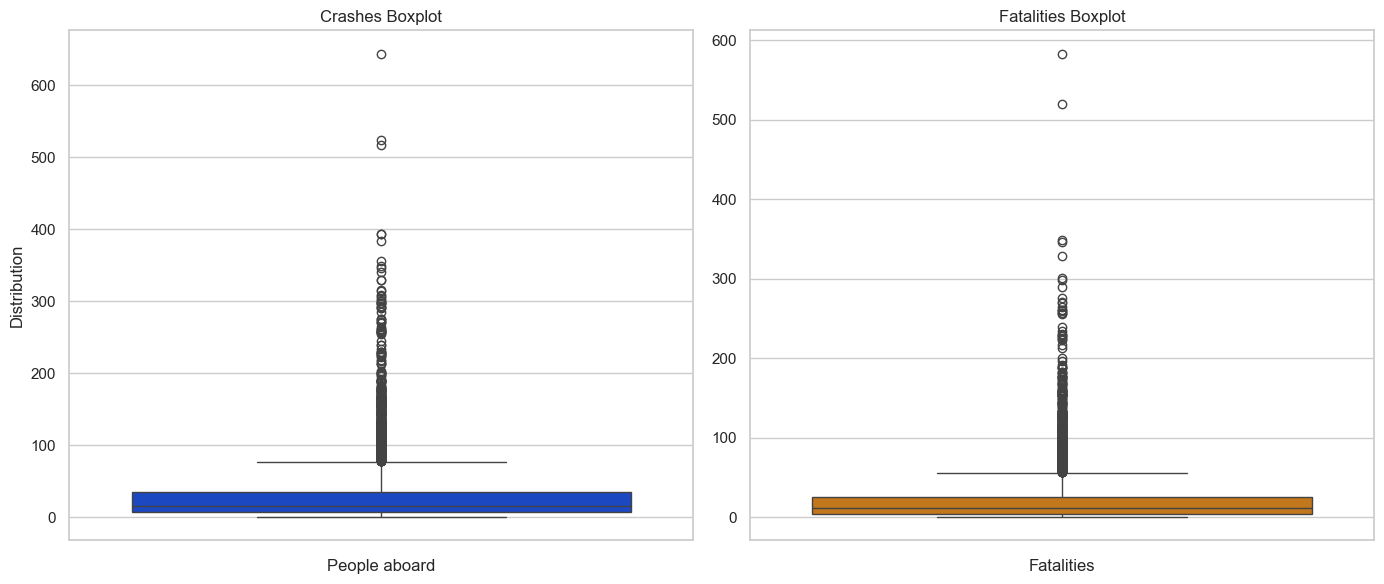

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

sns.boxplot(data=df, y='Aboard', color='#003DDE', ax=ax1)

ax1.set_xlabel('People aboard')
ax1.set_ylabel('Distribution')
ax1.set_title('Crashes Boxplot')

sns.boxplot(data=df, y='Fatalities', color='#DE7A00', ax=ax2)

ax2.set_xlabel('Fatalities')
ax2.set_ylabel('')
ax2.set_title('Fatalities Boxplot')

plt.tight_layout()

In [15]:
df[df['Aboard'] > 300]

,Date,Time,Location,Operator,Route,AC Type,Aboard,Fatalities,Fatalities Crew,Summary,Climatic,Criminal_Activities,Country,Military_Operation,Survivors,Weekday,Year,Month
2737,1974-03-03,11.0,"Near Ermenonville, France",Turkish Airlines (THY),Paris - London,McDonnell Douglas DC-10-10,346.0,346.0,11.0,The aircraft crashed shortly after takeoff fro...,True,False,France,False,0.0,Sunday,1974,3
2800,1975-04-04,16.0,"Saigon, South Vietnam",Military - U.S. Air Force,Saigon - Clark - Los Angeles,Lockheed C-5A Galaxy,330.0,155.0,5.0,The aircraft reported it was returning to Tan ...,True,False,Vietnam,True,175.0,Friday,1975,4
2902,1977-03-27,17.0,"Tenerife, Canary Islands",Pan American World Airways / KLM,Tenerife - Las Palmas / Tenerife - Las Palmas,Boeing B-747-121 / Boeing B-747-206B,644.0,583.0,23.0,Both aircraft were diverted to Tenerife becaus...,True,False,"Tenerife, Canary Islands",False,61.0,Sunday,1977,3
3093,1980-08-19,19.0,"Riyadh, Saudi Arabia",Saudi Arabian Airlines,Riyadh - Jeddah,Lockheed 1011-200 TriStar,301.0,301.0,14.0,The flight experienced a fire in the aft cargo...,False,False,Saudi Arabia,False,0.0,Tuesday,1980,8
3203,1982-09-13,12.0,"Near Malaga, Spain",Spantax,Malaga - New York City,McDonnell Douglas DC-10-30CF,394.0,50.0,3.0,The aircraft crashed during takeoff after inte...,False,False,Spain,False,344.0,Monday,1982,9
3337,1985-06-23,7.0,"Atlantic Ocean, 110 miles West of Ireland",Air India,Montreal - London,Boeing B-747-237B,329.0,329.0,22.0,The aircraft broke up in flight and crashed in...,True,False,Ireland,False,0.0,Sunday,1985,6
3341,1985-08-12,18.0,"Mt. Osutaka, near Ueno Village, Japan",Japan Air Lines,Tokyo - Osaka,Boeing B-747-SR46,524.0,520.0,15.0,The aircraft suffered an aft pressure bulkhead...,False,False,Japan,False,4.0,Monday,1985,8
3397,1986-09-05,6.0,"Karachi, Pakistan",Pan American World Airways,Bombay-Karachi-Frankfurt-New York,Boeing B-747-121,384.0,16.0,1.0,"While on the ground, four hijackers opened fir...",False,True,Pakistan,False,368.0,Friday,1986,9
3540,1989-02-24,2.0,"Honolulu, Hawaii",United Air Lines,Los Angeles - Honolulu - Auckland - Sydney,Boeing B-747-122,356.0,9.0,0.0,"After leaving Honolulu, on a flight from Los A...",True,False,United States,False,347.0,Friday,1989,2
3811,1992-12-21,7.0,"Faro, Algarve, Portugal",Martinair Holland NV,Amsterdam - Faro,McDonnell Douglas DC-10-30CF,340.0,56.0,2.0,While attempting a second landing in high wind...,True,False,Portugal,False,284.0,Monday,1992,12


I will retain all the outliers since they are not incorrect values.

In [16]:
df[(df['Fatalities'] < 1) & (df['Aboard'] > 0)].shape[0]    

72

Probability of all the passengers aboard to survive if a plane crash = 72 / 4992.

The number of crashes is 4992 because you need to assume that there is someone inside the aircraft and that reduces the sample space.

In [17]:
df[df['Military_Operation']].shape[0]

830

Probability of a plane crash being caused in military operations = 830 / 5016.

In [18]:
df[df['Climatic']].shape[0]

1459

Probability of all the passengers aboard to survive if a plane crash = 1459 / 5016.

In [19]:
df[df['Criminal_Activities']].shape[0]

33

Probability of a plane crash being caused by climatic conditions = 33 / 5016.

In [20]:
print(f"Probability to survive if you're present in a plane crash: {(df['Survivors'].sum() / df['Aboard'].sum())*100:.2f}%")

Probability to survive if you're present in a plane crash: 28.31%


In [21]:
df[(df['Fatalities'] > 0) & (df['Aboard'] == 0)]

,Date,Time,Location,Operator,Route,AC Type,Aboard,Fatalities,Fatalities Crew,Summary,Climatic,Criminal_Activities,Country,Military_Operation,Survivors,Weekday,Year,Month


Looking for inconsistent information

# `EDA` : Conclusions and aggregated information.

After an exhaustive searching for patterns and representative information, the most valuable indicators that i could find are the detailed here:

As you can see in the graphics "Crashes per Year", "Fatalities per Year" and "Acumulated number of Victims Timeline" the number of crashes or victims was relatively low in the beggining, this could potentially be attributed to the fact that commercial aeroplanes were in their early stages of adoption and the quantity of flights back then was pretty low. However between the years 1940 and 2000, the number of crashes and fatalities per year were in their highest, with an average of 62 crashes and 1525 fatalities per year, each accident also had a median of 14 fatalities. The highest number of deaths in a single accident occured in 1977 in the Canary Islands where 583 people lost their lives.

Something that i can appreciate looking at the information in the graphics and the pivot tables is that the Aircraft Douglas DC-3 could be easily missunderstood as a bad aircraft because is present in almost 7% of the crashes, but there are reasons that justifies it: 
- Is one of the most used aircraft in the past century, so, it's normal if the amount of crashes is a little higher than the expected. Something more representative could be the ratio of crashes and total flights in that aircraft.
- Was used in a lot of flights with military intentions and was one of the most present during the world war II.

One aircraft that appears more suspicious to me is the DHC-6, since the beginning of the century, 33 of 705 crashes correspond to this plane, it might be due to high popularity and the ratio of crash over total flights isn't that high but with the information that we have, it's an intelligent move, if possible, to avoid the aircraft DHC-6.

Another thing that could be easily missunderstood is the presence of the airline Aeroflot in almost 8% of the crashes, it could be a bad airline, but the graphics show that one of the mains reasons for that high appareance rate might be the hard wheather that Russia presents. When you select only the crashes that happened due to climatic conditions, Russia appears second, after the U.S.
This might be something to take into consideration if you're planning to travel across Russia, but, if you need to go there, don't be afraid. In the last 2 decades, the airline Aeroflot only had 1 airplane crash. Maybe the airplanes back in the 70's weren't good enough for the caothic weather of Russia.

One thing can be assured and it's that the US military was implicated in numerous crashes, with nearly 4% of all crashes involving them, this might be a bias in the dataset provided but it would make complete sense also if you take into consideration the historical context of the last century.
The US encountered significant challenges not only in the military flights but also in non-military. At least 16% of all flights crashes, excluding those related to military operations, take place in the US.Therefore, it's understandable why some Americans have an intense fear of flying when looking at the statistics.

For the peace of mind of the Americans and the people in general, the good news are that the crashes and fatalities have shown a marked downward trend for the last 20 years, it's also important to emphasize that we are talking about raw numbers, the total amount of crashes, this is an excellent notice, considering that the amount of flights should be closest to his all time high due to the constant evolution and the possibility of flight being opened to a higher number of human beings every year. 
If the trend presented in the number of plane crashes per year between the years 2000 to 2020 continues with the same behaviour, after the 2024 the amount of plane crashes per year should be in average, closest to 0.

The last thing i noticed when i was analizyng the graphics that i made was that we can't make any precise statement about the day of the week, the hour of the day or the month of the year in which occurs the higher number of accidents because it might be only a matter of traffic, the end of the year is a chaotic time because everyone is on holidays or trying to visit their families and the demand for flights is known to increase, also, for the hour of the day, we had a lot of missing values and that can interfere in the precision of my conclusions, therefore it's difficult for me to say to you, in which day, month or hour you have to book your flights, maybe there isn't a perfect time.

The last topic that I want to talk about are some interesting probabilities I've calculated and would like to share with you.
- 1: Probability of all the passengers aboard to survive if a plane crash = 1.44%
- 2: Probability of a plane crash being caused by climatic conditions = 30.8%
- 3: Probability of a plane crash being caused in military operations = 16.5%
- 4: Probability of a plane crash being involved in some criminal activity like hijacking or terrorism = 0.65%
- 5: Probability to survive if you're present in a plane crash: 28.31%

Perhaps you're thinking that the probability 1 and 4 are pretty high, remember that these probabilities are calculated assuming that the destiny of the airplane is to crash, the probability of that situation happening in a regular flight exceeds the scope of this projects, but trust me, it should be almost 0, don't be afraid and enjoy your flights!

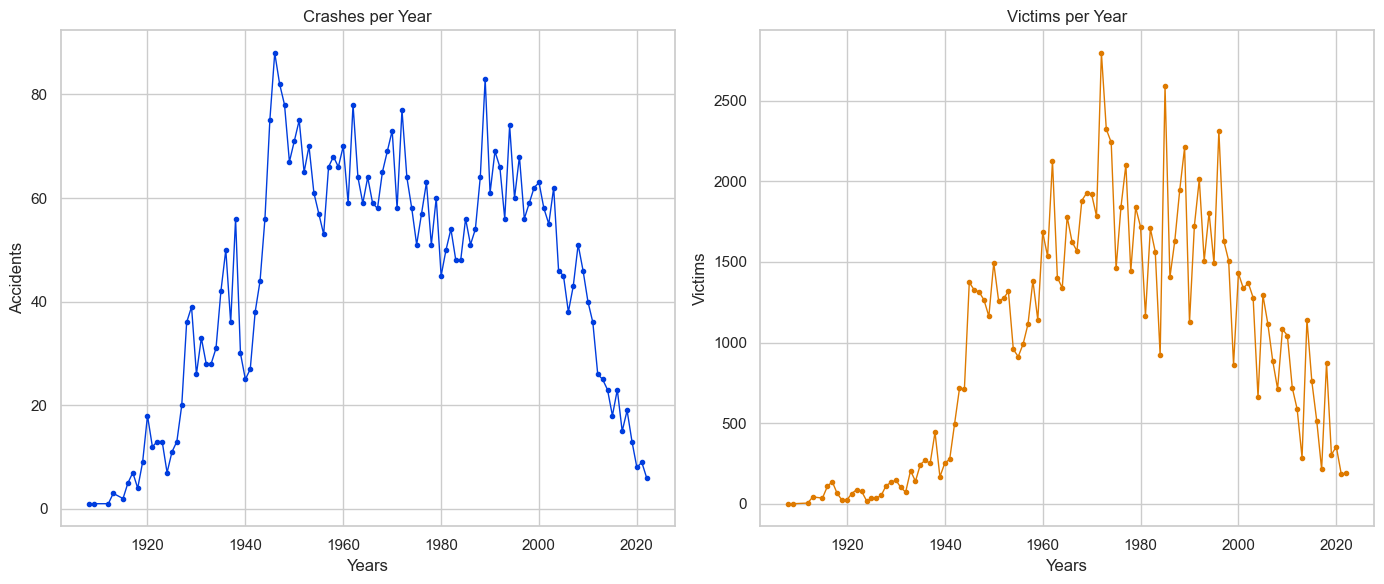

In [63]:
aux_df = df['Year'].value_counts().sort_index()
aux_df2 = df.groupby('Year')['Fatalities'].sum().sort_index()

category, values = aux_df.index, aux_df.values
category_victims, values_victims = aux_df2.index, aux_df2.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(category, values, color='#003DDE', marker = '.', linewidth=1)

ax1.set_xlabel('Years')
ax1.set_ylabel('Accidents')
ax1.set_title('Crashes per Year')

ax2.plot(category_victims, values_victims, color='#DE7A00', marker = '.', linewidth=1)

ax2.set_xlabel('Years')
ax2.set_ylabel('Victims')
ax2.set_title('Victims per Year')

plt.tight_layout()

The analysis of the number of crashes and fatalities through the years makes something clear, we are going in the right way, every year, less lifes are taken by airplane crashes.

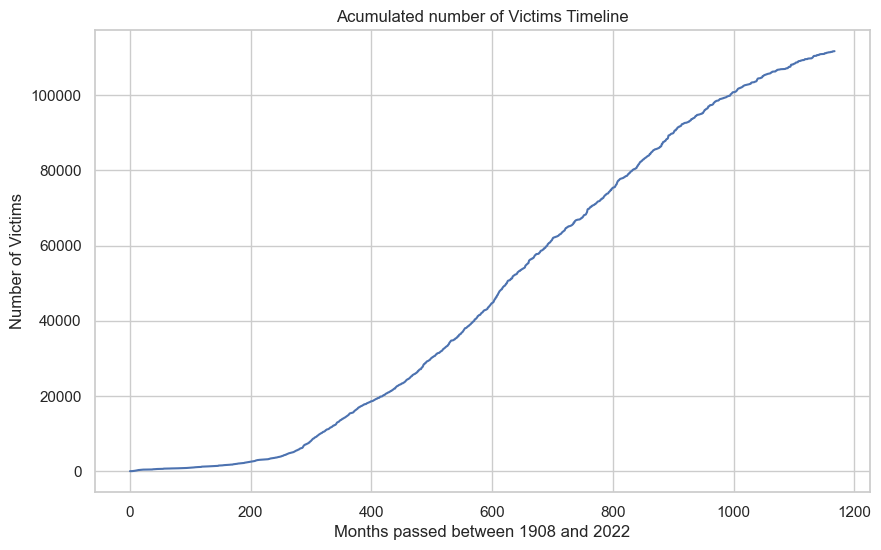

In [23]:
aux_df = df.groupby(['Year','Month'])['Fatalities'].sum().reset_index().cumsum()

fig , ax = plt.subplots(figsize=(10, 6))

ax.plot(aux_df.index, aux_df['Fatalities'], linestyle='-')

plt.xlabel('Months passed between 1908 and 2022')
plt.ylabel('Number of Victims')
plt.title('Acumulated number of Victims Timeline')
plt.show()

Here we can see observe what i mentioned in the last graph, at the end of the timeline the curve is flattening, it means that we are adding less deaths to the counter.

In [24]:
print(f'Year with the highest number of crashes: {df["Year"].value_counts().idxmax()}, crashes: {df["Year"].value_counts().max()}',
      f'Year with the highest number of fatalities: {df.groupby("Year")["Fatalities"].sum().idxmax()}, fatalities: {int(df.groupby("Year")["Fatalities"].sum().max())}', sep='\n')

Year with the highest number of crashes: 1946, crashes: 88
Year with the highest number of fatalities: 1972, fatalities: 2796


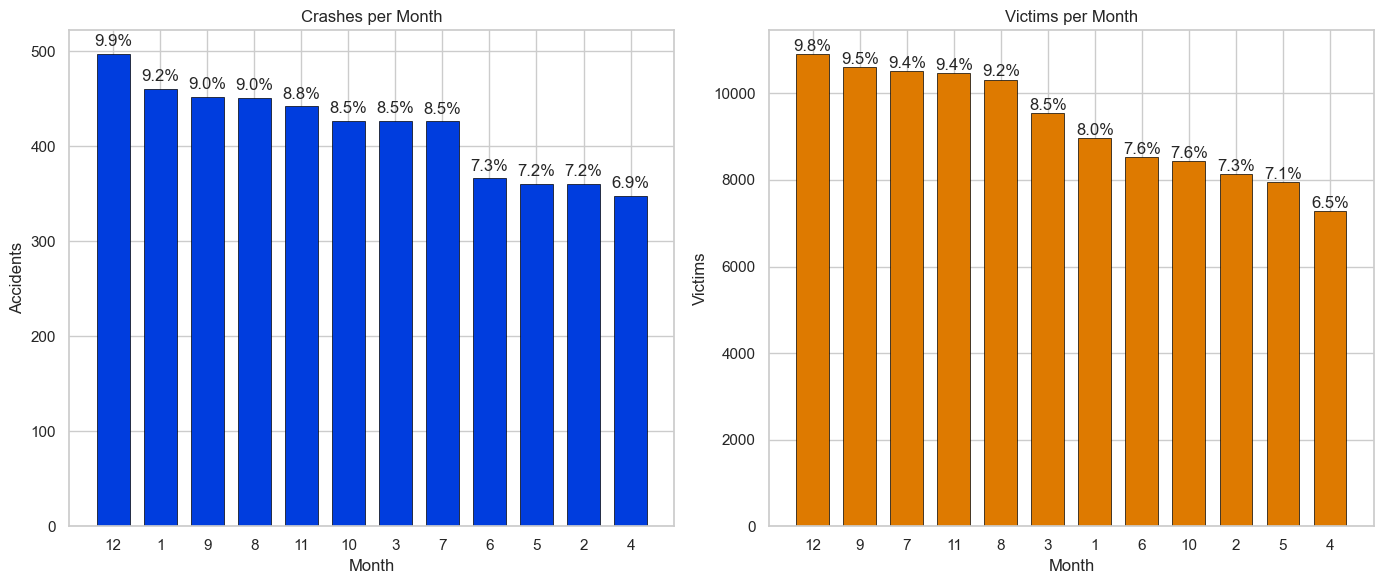

In [25]:
aux_df = df['Month'].value_counts().sort_values(ascending=False)
category_accidents, values_accidents = aux_df.index.astype(str), aux_df.values

aux_df = df.groupby('Month')['Fatalities'].sum().sort_values(ascending=False)
category_victims, values_victims = aux_df.index.astype(str), aux_df.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.bar(category_accidents, values_accidents, width=0.7, edgecolor='black', linewidth=0.5, color='#003DDE')

for i, v in enumerate(values_accidents):
    percentage = (v / sum(values_accidents)) * 100
    ax1.text(i, v + 5, f'{percentage:.1f}%', ha='center', va='bottom')

ax1.set_xlabel('Month')
ax1.set_ylabel('Accidents')
ax1.set_title('Crashes per Month')

ax2.bar(category_victims, values_victims, width=0.7, edgecolor='black', linewidth=0.5, color='#DE7A00')

for i, v in enumerate(values_victims):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(i, v + 5, f'{percentage:.1f}%', va='bottom', ha='center')

ax2.set_xlabel('Month')
ax2.set_ylabel('Victims')
ax2.set_title('Victims per Month')

plt.tight_layout()
plt.show()

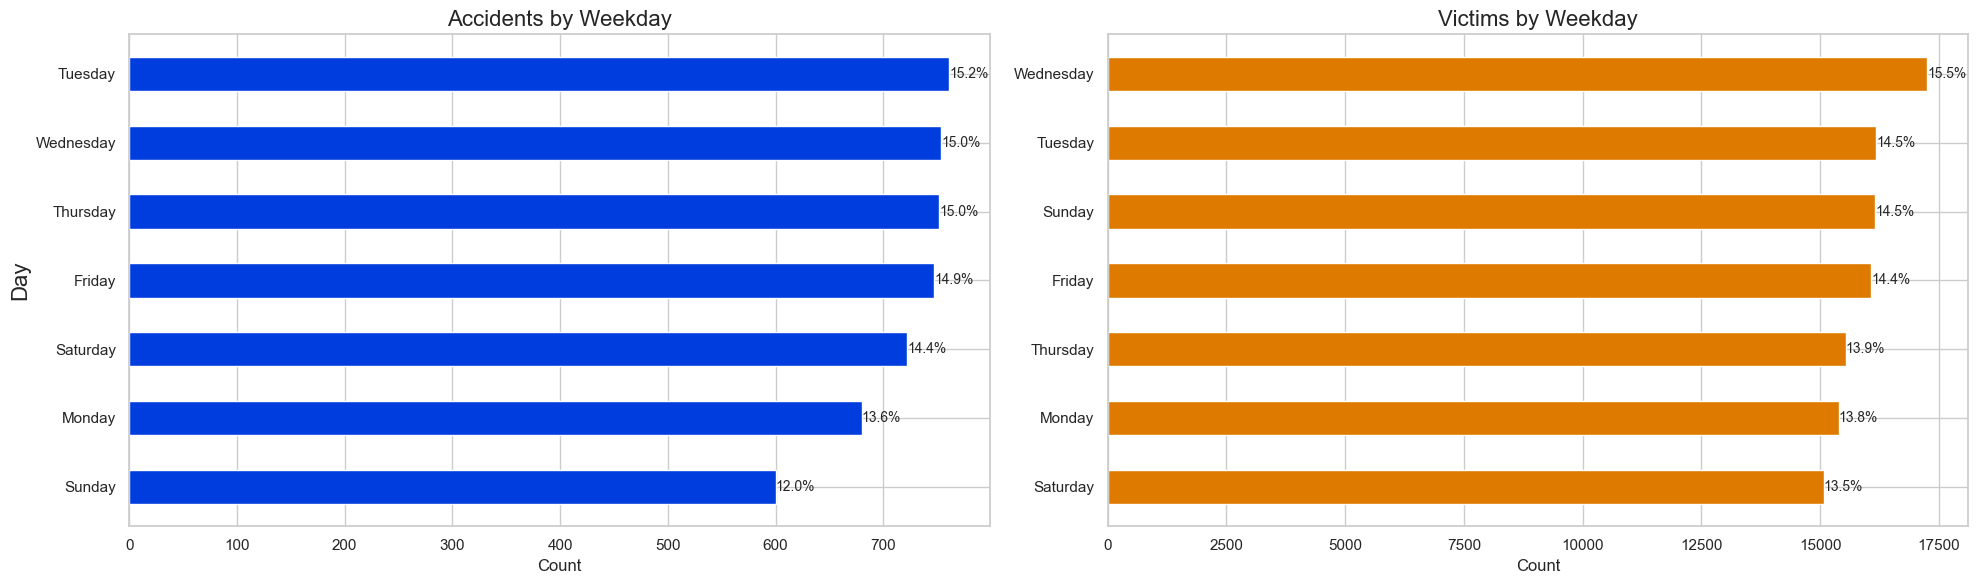

In [26]:
aux_df = df['Weekday'].value_counts().sort_values(ascending=True)
category_accidents, values_accidents = aux_df.index, aux_df.values

aux_df = df.groupby('Weekday')['Fatalities'].sum().sort_values(ascending=True)
category_victims, values_victims = aux_df.index, aux_df.values

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

ax1.barh(category_accidents, values_accidents, height=0.5, color='#003DDE')

for i, v in enumerate(values_accidents):
    percentage = (v / sum(values_accidents)) * 100
    ax1.text(v, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax1.set_xlabel('Count')
ax1.set_ylabel('Day', fontsize=16)
ax1.set_title('Accidents by Weekday', fontsize=16)

ax2.barh(category_victims, values_victims, height=0.5, color='#DE7A00')

for i, v in enumerate(values_victims):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(v, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax2.set_xlabel('Count')
ax2.set_title('Victims by Weekday', fontsize=16)

plt.tight_layout()
plt.show()

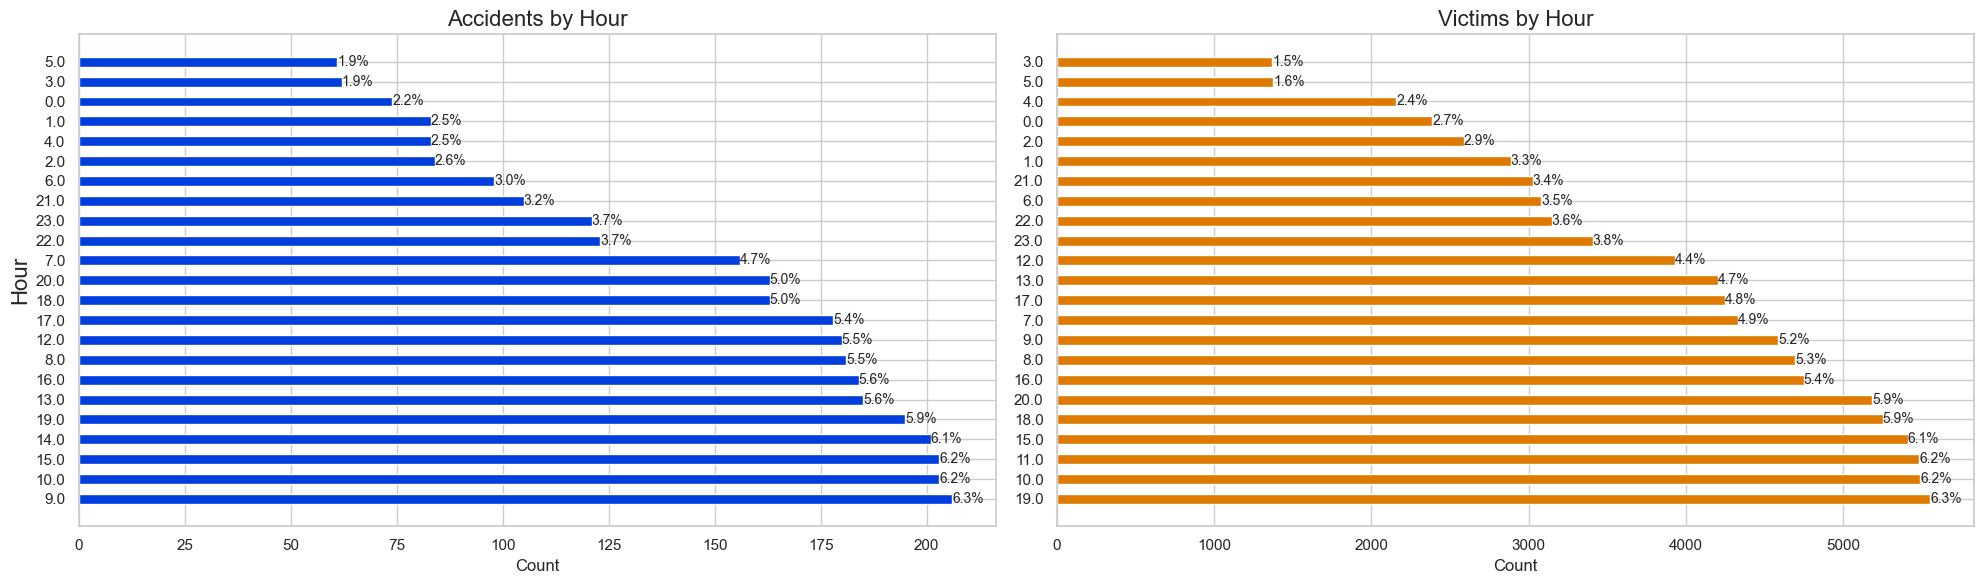

In [27]:
aux_df = df['Time'].value_counts().sort_values(ascending=False).iloc[1:]
category_accidents, values_accidents = aux_df.index.astype(str), aux_df.values

aux_df = df.groupby('Time')['Fatalities'].sum().sort_values(ascending=False).iloc[1:]
category_victims, values_victims = aux_df.index.astype(str), aux_df.values

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

ax1.barh(category_accidents, values_accidents, height=0.5, color='#003DDE')

for i, v in enumerate(values_accidents):
    percentage = (v / sum(values_accidents)) * 100
    ax1.text(v, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax1.set_xlabel('Count')
ax1.set_ylabel('Hour', fontsize=16)
ax1.set_title('Accidents by Hour', fontsize=16)

ax2.barh(category_victims, values_victims, height=0.5, color='#DE7A00')

for i, v in enumerate(values_victims):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(v, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax2.set_xlabel('Count')
ax2.set_title('Victims by Hour', fontsize=16)

plt.tight_layout()
plt.show()

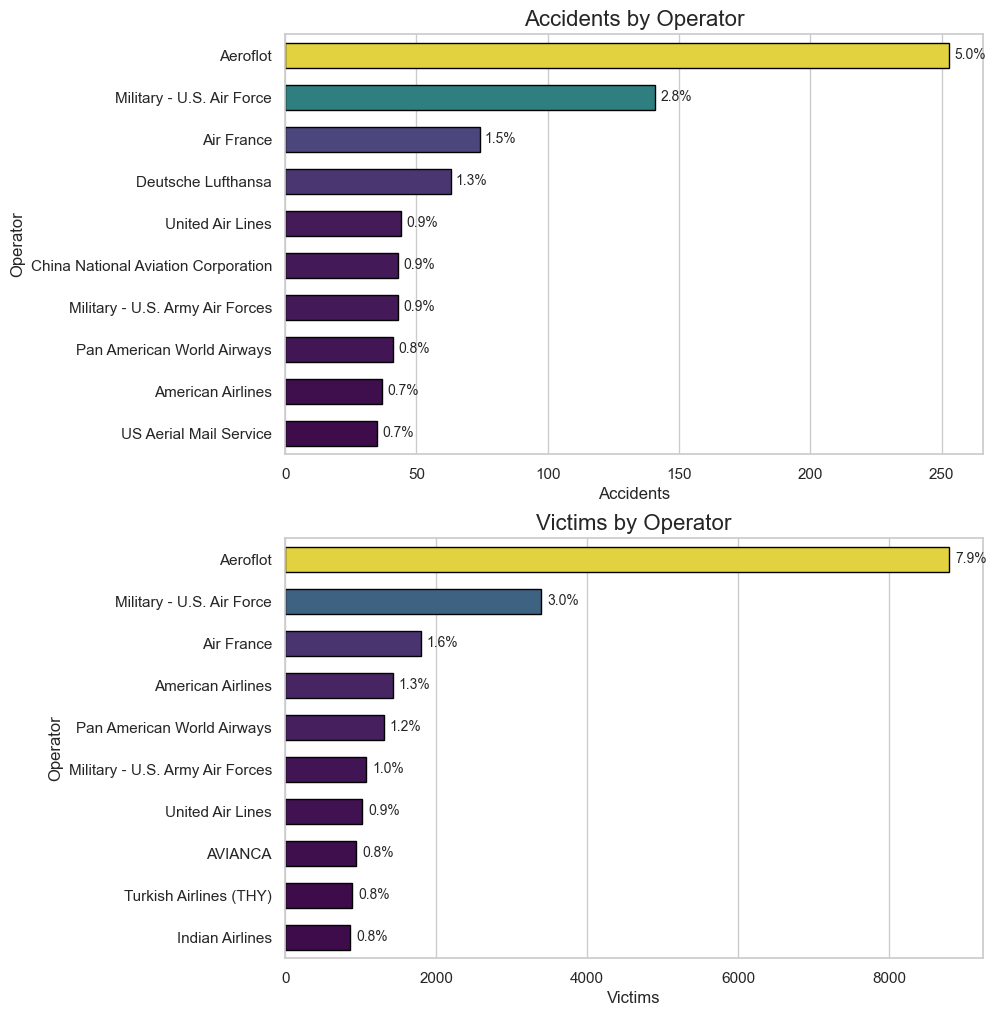

In [28]:
aux_df = df['Operator'].value_counts()
category_accidents, values_accidents = aux_df.index[:10], aux_df.values[:10]

aux_df = df.groupby('Operator')['Fatalities'].sum().sort_values(ascending=False)
category_victims, values_victims = aux_df.index, aux_df.values

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,12))

sns.barplot(x=values_accidents, y=category_accidents, ax=ax1, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_accidents, legend=False)

for i, v in enumerate(values_accidents):
    percentage = (v / len(df)) * 100
    ax1.text(v + 2, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax1.set_xlabel('Accidents')
ax1.set_ylabel('Operator')
ax1.set_title('Accidents by Operator', fontsize=16)

sns.barplot(x=values_victims[:10], y=category_victims[:10], ax=ax2, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_victims[:10], legend=False)

for i, v in enumerate(values_victims[:10]):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(v + 80, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax2.set_xlabel('Victims')
ax2.set_ylabel('Operator')
ax2.set_title('Victims by Operator', fontsize=16)

plt.show()

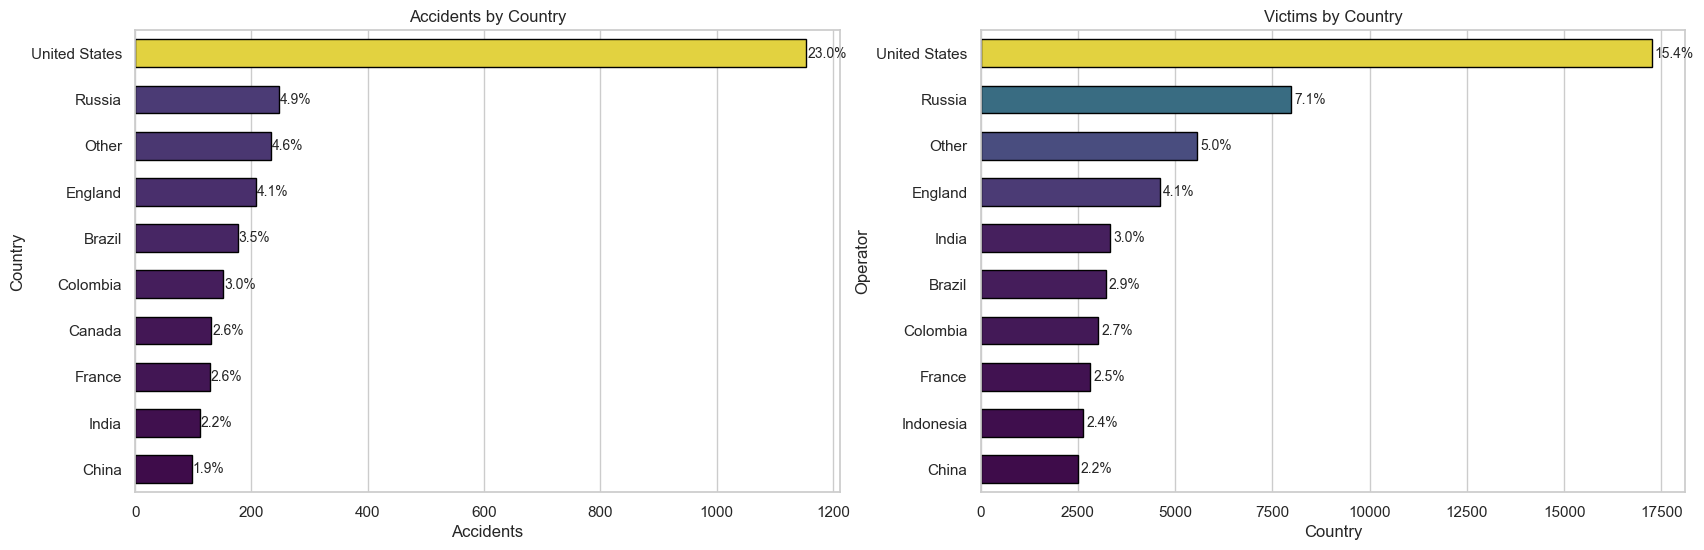

In [69]:
aux_df = df['Country'].value_counts()
category_accidents, values_accidents = aux_df.index[:10], aux_df.values[:10]

aux_df = df.groupby('Country')['Fatalities'].sum().sort_values(ascending=False)
category_victims, values_victims = aux_df.index, aux_df.values

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

sns.barplot(x=values_accidents, y=category_accidents, ax=ax1, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_accidents, legend=False)

for i, v in enumerate(values_accidents):
    percentage = (v / len(df)) * 100
    ax1.text(v + 2, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax1.set_xlabel('Accidents')
ax1.set_ylabel('Country')
ax1.set_title('Accidents by Country')

sns.barplot(x=values_victims[:10], y=category_victims[:10], ax=ax2, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_victims[:10], legend=False)

for i, v in enumerate(values_victims[:10]):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(v + 80, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax2.set_xlabel('Country')
ax2.set_ylabel('Operator')
ax2.set_title('Victims by Country')

plt.show()

In [30]:
df['Route'].value_counts() / len(df)

Route
Unknown                                                    0.152113
Training                                                   0.019139
Sightseeing                                                0.006180
Test flight                                                0.004585
Sao Paulo - Rio de Janeiro                                 0.001396
                                                             ...   
Fort Lamy, Chad - Marseilles, France                       0.000199
McChord - Lawton                                           0.000199
Traing                                                     0.000199
Rome  - Lisbon -  Madrid - Santa Maria, Azores -Caracas    0.000199
Medellín - Pizarro                                         0.000199
Name: count, Length: 3845, dtype: float64

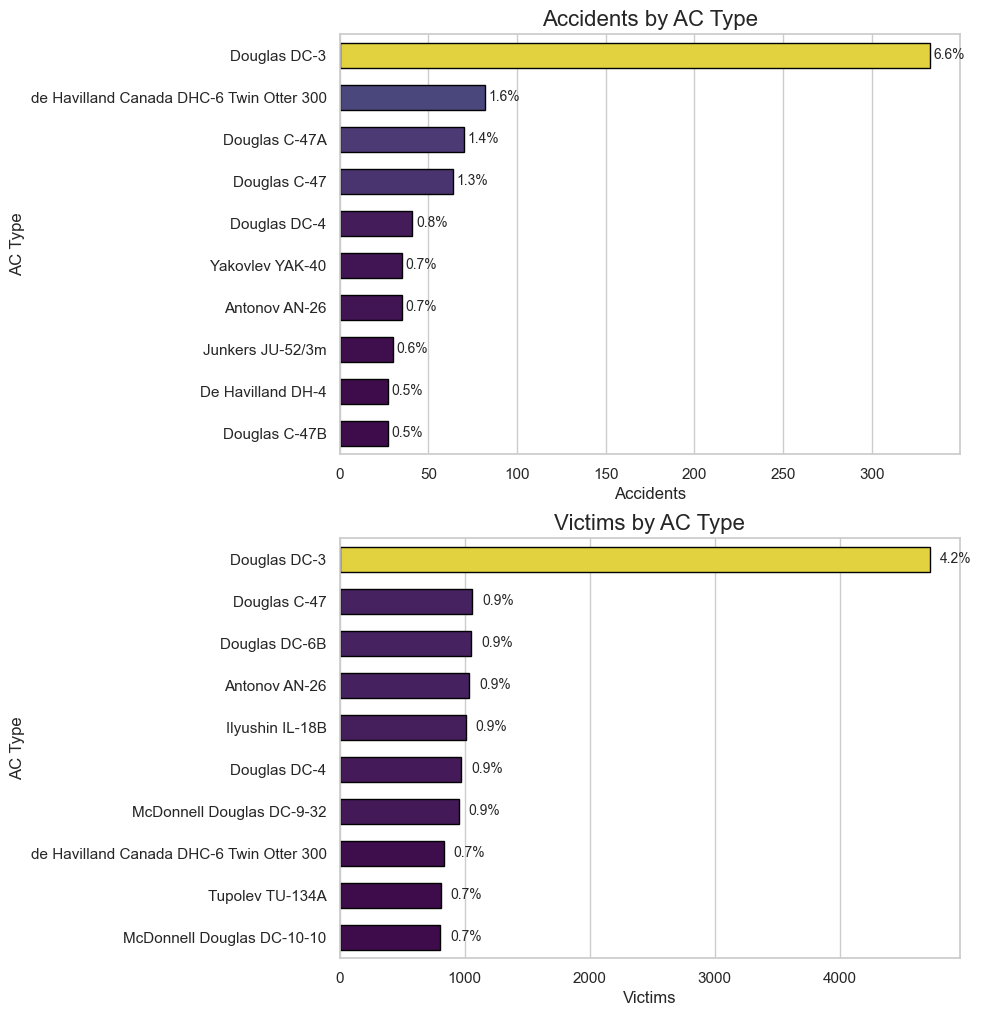

In [31]:
aux_df = df['AC Type'].value_counts()
category_accidents, values_accidents = aux_df.index[:10], aux_df.values[:10]

aux_df = df.groupby('AC Type')['Fatalities'].sum().sort_values(ascending=False)
category_victims, values_victims = aux_df.index, aux_df.values

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

sns.barplot(x=values_accidents, y=category_accidents, ax=ax1, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_accidents, legend=False)

for i, v in enumerate(values_accidents):
    percentage = (v / len(df)) * 100
    ax1.text(v + 2, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax1.set_xlabel('Accidents')
ax1.set_ylabel('AC Type')
ax1.set_title('Accidents by AC Type', fontsize=16)

sns.barplot(x=values_victims[:10], y=category_victims[:10], ax=ax2, width=0.6, edgecolor='black', linewidth=1, palette='viridis', hue=values_victims[:10], legend=False)

for i, v in enumerate(values_victims[:10]):
    percentage = (v / sum(values_victims)) * 100
    ax2.text(v + 80, i, f'{percentage:.1f}%', va='center', fontsize=10)

ax2.set_xlabel('Victims')
ax2.set_ylabel('AC Type')
ax2.set_title('Victims by AC Type', fontsize=16)

plt.show()

In [32]:
highest = df[(df['Year'] > 1940) & (df['Year'] < 2000)]

In [33]:
print(f'The mean amount of crashes per year between the years 1940 and 2000 was: '
    f'{math.ceil(highest["Year"].value_counts().mean())} '
    'and the mean amount of fatalities was: '
    f'{math.ceil(highest.groupby("Year")["Fatalities"].sum().mean())}')

The mean amount of crashes per year between the years 1940 and 2000 was: 62 and the mean amount of fatalities was: 1525


In [34]:
highest['Fatalities'].median()

14.0

In [35]:
highest.loc[highest['Fatalities'].idxmax()]

Date                                                 1977-03-27 00:00:00
Time                                                                17.0
Location                                        Tenerife, Canary Islands
Operator                                Pan American World Airways / KLM
Route                      Tenerife - Las Palmas / Tenerife - Las Palmas
AC Type                             Boeing B-747-121 / Boeing B-747-206B
Aboard                                                             644.0
Fatalities                                                         583.0
Fatalities Crew                                                     23.0
Summary                Both aircraft were diverted to Tenerife becaus...
Climatic                                                            True
Criminal_Activities                                                False
Country                                         Tenerife, Canary Islands
Military_Operation                                 

Biggest accident recored in the dataset

In [36]:
ww2 = df[(df['Year'] > 1938) & (df['Year'] < 1946 )]

Crashes that occurs during the WW2.

In [37]:
ww2.groupby('Country').size().sort_values(ascending=False)[:10]

Country
United States    61
China            25
England          23
Australia        18
France           13
Brazil           12
Ocean            11
India            10
Guinea            9
Italy             8
dtype: int64

Countries with the highest number of crashes during the time of the world war II.

As expected, we can see how the demographic zone sorrounding Europe and Asia is highly present among these countries.

In [38]:
ww2.groupby('AC Type').size().sort_values(ascending=False)[:10]

AC Type
Douglas DC-3                     27
Douglas C-47                     17
Junkers JU-52/3m                 15
Lockheed 18 Lodestar              6
Consolidated LB-30A Liberator     6
Douglas C-47-DL                   5
Douglas C-53                      5
Douglas C-47A-DL                  5
Unknown                           4
Lockheed Hudson                   4
dtype: int64

Most crashed aircrafts during the world war II.

In [39]:
df[df['Military_Operation']].groupby('Operator').size().sort_values(ascending=False)[:10]

Operator
Military - U.S. Air Force                 141
Military - U.S. Army Air Forces            43
Military - Royal Air Force                 32
Military - U.S. Navy                       30
Military - U.S. Army                       27
Military -Royal Air Force                  22
Military - Afghan Republican Air Force     15
Military - German Navy                     15
Military - Indian Air Force                15
Military - Russian Air Force               15
dtype: int64

Most involved operator in military crashes.

In [40]:
df[df['Military_Operation']].groupby('Country').size().sort_values(ascending=False)[:10]

Country
United States    156
England           44
Vietnam           34
India             27
Afghanistan       26
Russia            26
Ocean             21
France            19
Italy             16
Iran              16
dtype: int64

Most involved countries/cities in military crashes.

In [41]:
df[df['Military_Operation']].groupby('AC Type').size().sort_values(ascending=False)[:10]

AC Type
Douglas C-47                27
Lockheed C-130H             15
Lockheed C-130H Hercules    15
Antonov AN-26               15
Douglas C-47B               14
Douglas C-47A               11
Douglas DC-3                10
Antonov AN-12               10
Boeing KC-135A               9
Mil Mi-8 (helicopter)        9
dtype: int64

Most involved aircrafts in military crashes.

In [42]:
df[df['Climatic']].groupby('Operator').size().sort_values(ascending=False)[:10]

Operator
Aeroflot                      53
Military - U.S. Air Force     38
Deutsche Lufthansa            20
American Airlines             18
Air France                    17
Private                       16
United Air Lines              15
Indian Airlines               13
Philippine Air Lines          12
Pan American World Airways    12
dtype: int64

Operator with the highest number of crashes due to climatic reasons.

In [43]:
df[df['Climatic']].groupby('Country').size().sort_values(ascending=False)[:10]

Country
United States    449
Russia            80
England           48
Canada            47
India             45
France            40
Colombia          38
Brazil            36
Indonesia         30
Mexico            30
dtype: int64

Countries with the highest number of crashes due to climatic reasons.

In [44]:
df[df['Climatic']].groupby('AC Type').size().sort_values(ascending=False)[:10]

AC Type
Douglas DC-3                                83
de Havilland Canada DHC-6 Twin Otter 300    31
Douglas C-47                                22
Douglas C-47A                               14
Junkers JU-52/3m                            11
Yakovlev YAK-40                              9
Tupolev TU-134A                              9
Boeing 40                                    8
De Havilland DH-4                            8
McDonnell Douglas DC-9-32                    8
dtype: int64

Aircrafts with the highest number of crashes due to climatic reasons.

In [45]:
recent = df[df['Year'] >= 2000]

Crashes after the year 2000

In [46]:
recent.head()

,Date,Time,Location,Operator,Route,AC Type,Aboard,Fatalities,Fatalities Crew,Summary,Climatic,Criminal_Activities,Country,Military_Operation,Survivors,Weekday,Year,Month
4248,2000-01-05,NaN,"Abuja, Nigeria",Skypower Express Airways,Lagos - Abuja,Embraer 110P1A Bandeirante,16.0,1.0,0.0,During a visual approach the aircraft stalled ...,False,False,Niger,False,15.0,Wednesday,2000,1
4249,2000-01-10,17.0,"Niederhasli, Switzerland",Crossair,Zürich - Dresden,Saab 340B,10.0,10.0,3.0,"The aircraft crashed shortly after taking off,...",True,False,Switzerland,False,0.0,Monday,2000,1
4250,2000-01-13,12.0,"Off Marsa el-Brega, Libya",Avisto,Tripoli IAP - Marsa el-Brega,Shorts 360-300,41.0,22.0,1.0,The aircraft was on a flight from Tripoli to M...,True,False,Libya,False,19.0,Thursday,2000,1
4251,2000-01-15,13.0,"San Jose, Costa Rica",TACA,San Jose - Tortuguero,Let 410UVP-E,20.0,5.0,1.0,The aircraft was not able to maintain altitude...,False,False,Costa Rica,False,15.0,Saturday,2000,1
4252,2000-01-30,21.0,"Off Abidjan, Ivory Coast",Kenya Airways,Abidjan - Lagos,AirbusA310-304,179.0,169.0,10.0,The aircraft crashed into the Atlantic Ocean t...,False,False,Ivory Coast,False,10.0,Sunday,2000,1


In [47]:
recent.shape[0]

768

In [48]:
recent[recent['Climatic']].shape[0]

292

Number of crashes caused by climatic conditions between the years 2000 and 2022

In [49]:
recent[recent['Military_Operation']].shape[0]

134

Number of crashes involved in military operations between the years 2000 and 2022

In [50]:
recent[(recent['Military_Operation']) & (recent['Climatic'])].shape[0]

45

Number of crashes involved in military operations caused by climatic conditions between the years 2000 and 2022

In [51]:
recent['AC Type'].value_counts()[:10]

AC Type
de Havilland Canada DHC-6 Twin Otter 300    16
Let 410UVP                                   7
Antonov AN-26                                7
Antonov An-26                                6
Learjet 35A                                  5
Let 410UVP-E                                 5
Cessna 208B Grand Caravan                    5
Antonov AN-28                                5
Lockheed C-130H Hercules                     4
Mil Mi-8                                     4
Name: count, dtype: int64

Aircrafts with the higher amount of crashes between the years 2000 and 2022

In [52]:
recent[recent['Operator'] == 'Aeroflot']

,Date,Time,Location,Operator,Route,AC Type,Aboard,Fatalities,Fatalities Crew,Summary,Climatic,Criminal_Activities,Country,Military_Operation,Survivors,Weekday,Year,Month
4697,2008-09-14,3.0,"Perm, Russia",Aeroflot,Moscow - Perm,Boeing B-737-505,88.0,88.0,6.0,The aircraft crashed into a ravine adjacent to...,False,False,Russia,False,0.0,Sunday,2008,9


Crashes of the airline Aeroflot after the year 2000 

In [53]:
recent[recent['AC Type'].str.contains('DHC-6')].shape[0]

33

Number of crashes of the aircraft DHC-6 after the year 2000 

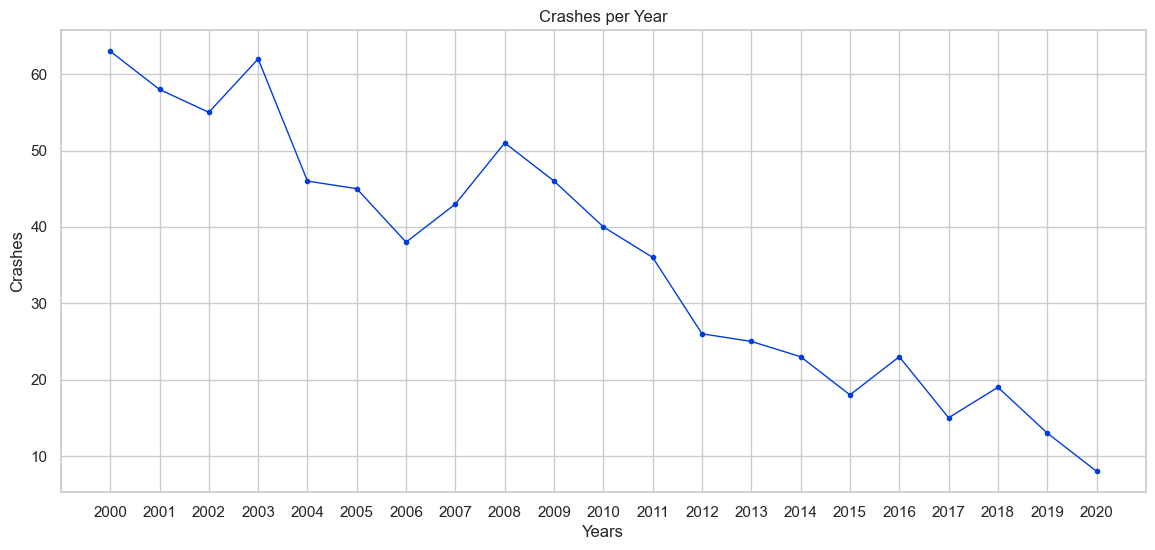

In [54]:
aux_df = recent['Year'].value_counts().sort_index()

category, values = aux_df.index[:-2].astype('str'), aux_df.values[:-2]

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(category, values, color='#003DDE', marker = ".", linewidth=1)

ax1.set_xlabel('Years')
ax1.set_ylabel('Crashes')
ax1.set_title('Crashes per Year')

plt.show()

Look how the trend will continue after 2020

In [55]:
lr = LinearRegression()
x = np.array(recent['Year'].value_counts().sort_index().index[:-2]).reshape(-1,1)
y = recent['Year'].value_counts().sort_index().values[:-2]

In [56]:
lr.fit(x, y);

In [57]:
x_pred = np.arange(2020,2031).reshape(-1,1)
y_pred = lr.predict(x_pred)

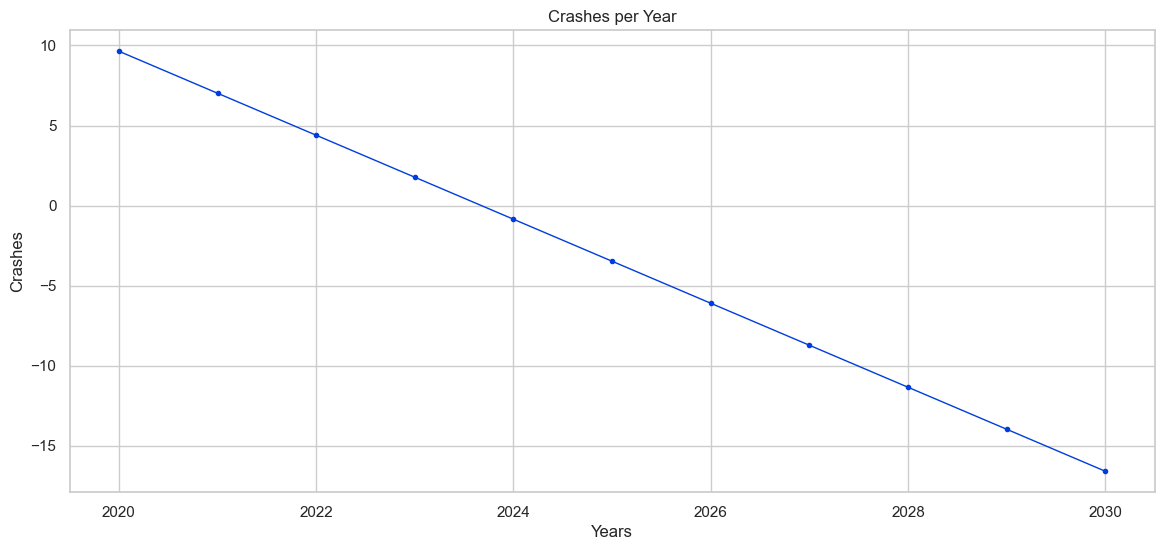

In [58]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x_pred, y_pred, color='#003DDE', marker = ".", linewidth=1)

ax1.set_xlabel('Years')
ax1.set_ylabel('Crashes')
ax1.set_title('Crashes per Year')

plt.show()

In [70]:
df.to_csv('src/datasets/clean.csv', index=False)